In [2]:
#default_exp utils.traininghelpersfastai

In [3]:
#hide
from nbdev.showdoc import *

# Training Helpers

In [5]:
 #export 
from rfpimp import *
from sklearn.metrics import classification_report, confusion_matrix, auc, roc_curve, balanced_accuracy_score
from fastai.basics import *
from fastai.tabular.all import *

import logging
import scikitplot as skplt
import numpy as np
import matplotlib.pyplot as plt

logging.basicConfig(level=logging.INFO)
logging.getLogger("azure.core").setLevel(logging.WARNING)
logging.getLogger("urllib3.connectionpool").setLevel(logging.CRITICAL)
logging.getLogger("snowflake.connector").setLevel(logging.WARNING)
logger = logging.getLogger(__name__)

## Method Generic Functions

### ``change_dl_to_pandas_df``

In [6]:
#export


def change_dl_to_pandas_df(dl, valid: bool = True, label: bool = True):
    """
    Helper function to make data frames for the train/validation sets
    that come from a dataloader that will be used in another type of model

    Args:
    * dl (TabularDataloaders): TabularDataLoader
    * valid (bool, optional): Does the dataloader have a validation set. Defaults to True.
    * label (bool, optional): Do we have the labels. Defaults to True.

    Returns:
    * list: depends on function
    """
    X_train = dl.train.xs
    if label is True:
        y_train = dl.train.y
        logging.info(f'Label size {len(y_train)}')
        assert len(y_train) == X_train.shape[0], 'Label size does not match Training Rows'
    logging.info(f'Training/Test set shape {X_train.shape}')
    if valid is True:
        X_valid = dl.valid.xs
        logging.info(f'Validation set shape {X_valid.shape}')
        y_valid = dl.valid.y
        logging.info(f'Label size {len(y_valid)}')
        assert len(y_valid) == X_valid.shape[0], 'Label size does not match Training Rows'
        return X_train, y_train, X_valid, y_valid
    return X_train, y_train

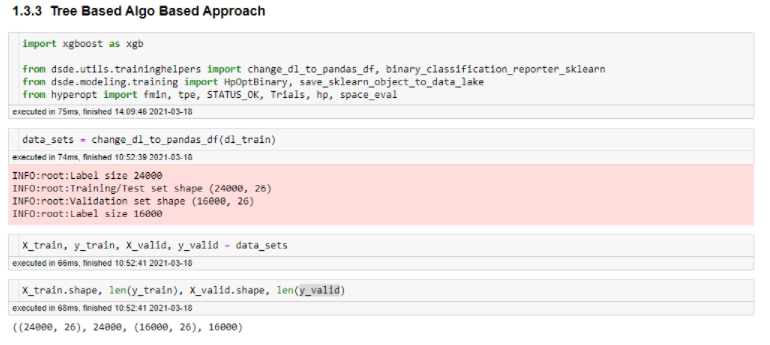

### ``binary_classification_reporter_fastai_dl``

In [11]:
#export


def binary_classification_reporter_fastai_dl(probs, y=None, threshold=0.5, plot=False, bins=5):
    """
    Create a report on dl results for a BC problem and allows for
    different threshold cut off points

    Args:
    * probs (list): pytorch tensor that will change to a numpy array
    * y (list, optional): the actuals. Defaults to None.
    * threshold (float, optional): logit cut off point for analysis.
        Defaults to 0.4.
    * plot (bool, optional): in jupyter notebook there are charts that will display.
        Defaults to False.
    * bins (int, optional): histogram bin size. Defaults to 5.
    """
    dlprobs = to_np(probs[:, 1])
    dlpreds_cutt_off = np.where(dlprobs > threshold, 1, 0)
    preds = to_np(probs.argmax(1))
    logging.info(f"Percent Predicted Set {'{:.3}%'.format(preds.sum()/len(probs))}")
    logging.info(f"Percent Predicted Set at {threshold} threshold {'{:.3}%'.format(dlpreds_cutt_off.sum()/len(probs))}")
    if plot is True:
        skplt.metrics.plot_roc(y, probs)
        plt.show()
        skplt.metrics.plot_precision_recall(y, probs)
        plt.show()
        plt.title('Histogram of Probability Distrubtion')
        plt.xlabel('probabilities')
        plt.ylabel('Volume')
        plt.hist(dlprobs, bins=bins)
        plt.show()
    if y is not None:
        logging.info(f"Percent Return Actual Set {'{:.3}%'.format(y.sum()/len(probs))}")
        accuracy_value = balanced_accuracy_score(y_true=y, y_pred=dlpreds_cutt_off)
        cm = confusion_matrix(y, preds)
        logging.info("Accuracy For Each Class")
        logging.info(cm.diagonal()/cm.sum(axis=1))
        logging.info(cm)
        logging.info(classification_report(y, preds))
        cm = confusion_matrix(y, dlpreds_cutt_off)
        logging.info("Accuracy For Each Class 0.4 Cut Off for Model")
        logging.info(cm.diagonal()/cm.sum(axis=1))
        logging.info(cm)
        logging.info(classification_report(y, dlpreds_cutt_off))
        fpr, tpr, thresholds = roc_curve(y, dlprobs)
        val_auc = auc(fpr, tpr)
        logging.info(f'AUC {val_auc}')
        return val_auc, accuracy_value

### ``Fast_Interpretation``

In [8]:
#export


class Fast_Interpretation():
    """
    TODO: Build Example

    Interpretation base class, can be inherited for task specific Interpretation classes
    """

    def __init__(self, dl, preds, targs, decoded, losses):
        store_attr()

    def __getitem__(self, idxs):
        "Get the the inputs, preds, targs, decoded outputs, and losses at `idxs`"
        if isinstance(idxs, Tensor):
            idxs = idxs.tolist()
        if not is_listy(idxs):
            idxs = [idxs]
        attrs = 'preds,targs,decoded,losses'
        res = L([getattr(self, attr)[idxs] for attr in attrs.split(',')])
        inps = [self.dl.do_item(o)[:self.dl.n_inp] for o in idxs]
        inps = self.dl.after_batch(to_device(self.dl.do_batch(inps), self.dl.device))
        return inps + res

    @classmethod
    def from_learner(cls, learn, ds_idx=1, dl=None, act=None):
        "Construct interpretation object from a learner"
        if dl is None:
            dl = learn.dls[ds_idx]
        return cls(dl, *learn.get_preds(dl=dl, with_input=False, with_loss=True, with_decoded=True, act=None))

    def top_losses(self, k=None, largest=True):
        "`k` largest(/smallest) losses and indexes, defaulting to all losses (sorted by `largest`)."
        return self.losses.topk(ifnone(k, len(self.losses)), largest=largest)

    def plot_top_losses(self, k, largest=True, **kwargs):
        losses, idx = self.top_losses(k, largest)
        inps, preds, targs, decoded, _ = self[idx]
        if not isinstance(inps, tuple):
            inps = (inps,)
        b = inps + (targs,)
        x, y, its = self.dl._pre_show_batch(b, max_n=k)
        b_out = inps + (decoded,)
        x1, y1, outs = self.dl._pre_show_batch(b_out, max_n=k)
        if its is not None:
            plot_top_losses(x, y, its, outs.itemgot(slice(len(inps), None)), preds, losses, **kwargs)

### ``fastai_model_top_losses``

In [9]:
# export


def fastai_model_top_losses(learner,
                            dl,
                            n: int = 10,
                            labels: bool = False,
                            probs: list = None):
    """
    TODO: Build out example
    Function currently will give us the top losses of the DL model

    Args:
    * learner (fastai.learner): Learner
    * dl (fastai.Dataloader): Dataloaderr
    * n (int, optional): how many do we want to see. Defaults to 10.
    * labels (bool, optional): do we have the labels. Defaults to False.
    * probs (list, optional): probabilities. Defaults to None.

    Returns:
    * pd.DataFrame(): returns data frame
    """
    interp = Interpretation.from_learner(learner, dl=dl)
    top_losses = interp.top_losses(n)
    df = None
    logging.info('Lost this for some odd reason oops')
    # df = return_org_df(dl.train.xs[dl.train.xs.index.isin(top_losses[1])], dl)
    df['loss'] = top_losses[0]
    if labels:
        df['target'] = dl.train.y
    if probs is not None:
        probs = np.take(to_np(probs), top_losses[1], 0)
        df['class_0'] = probs[:, 0]
        df['class_1'] = probs[:, 1]
    return df

# Create

In [12]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 01_azure.ipynb.
Converted 02_utils_dataframes.ipynb.
Converted 02_utils_parseyaml.ipynb.
Converted 02_utils_stfp.ipynb.
Converted 02_utils_traininghelpers.ipynb.
Converted 02_utils_traininghelpers_fastai.ipynb.
Converted 03_dstools_preparedata.ipynb.
Converted 04_snowflake_copyinto.ipynb.
Converted 04_snowflake_copyinto2.ipynb.
Converted 04_snowflake_query.ipynb.
Converted 05_azure_wrappers.ipynb.
Converted 06_modeling_inference.ipynb.
Converted 06_modeling_inference_fastai.ipynb.
Converted 06_modeling_premodel.ipynb.
Converted 06_modeling_preprocessing.ipynb.
Converted 06_modeling_preprocessing_fastai.ipynb.
Converted 06_modeling_training.ipynb.
Converted 06_modeling_training_fastai.ipynb.
Converted 07_Binary_Classification_Fastai_Example_Notebook.ipynb.
Converted 08_yaml_ingestion_binary_classification.ipynb.
Converted index.ipynb.
